# Fake News Detection : Cross-dataset evaluation

In [18]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score

## 1. Load data

### ISOT dataset

In [19]:
df_fake = pd.read_csv("data/Fake.csv")
df_true = pd.read_csv("data/True.csv")

df_fake["label"] = 0 # label 0 for fake news
df_true["label"] = 1 # label 1 for real news

# Combine the two datasets
df_isot = pd.concat([df_fake, df_true]).sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data
X_isot = df_isot["text"]
y_isot = df_isot["label"]

### Fake or Real dataset

In [20]:
df_for = pd.read_csv("data/fake_or_real_news.csv")
# Drop first column
df_for = df_for.drop(df_for.columns[0], axis=1)
# Label 0 for fake news and label 1 for real news
df_for["label"] = df_for["label"].map({"FAKE": 0, "REAL": 1})
# Split the data
X_for = df_for["text"]
y_for = df_for["label"]

## 2. Load features

In [21]:
def load_feature_dict(folder_path):
    feature_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".pkl"):
            feature_name = filename.replace("_features.pkl", "")
            with open(os.path.join(folder_path, filename), "rb") as f:
                feature_dict[feature_name] = pickle.load(f)
    return feature_dict

In [22]:
features_dict_isot = load_feature_dict("features/isot")
features_dict_for = load_feature_dict("features/FoR")

## 3. Cross-dataset evaluation

In [23]:
def cross_dataset_evaluation(features_dict_test, y_test, model_dir="models/isot"):
    results = []

    for feature_name, X_test in features_dict_test.items():
        for model_file in os.listdir(model_dir):
            if model_file.startswith(feature_name):
                model_path = os.path.join(model_dir, model_file)
                model = joblib.load(model_path)
                y_pred = model.predict(X_test)
                results.append({
                    "feature": feature_name,
                    "model": model_file.replace(f"{feature_name}_", "").replace(".joblib", ""),
                    "accuracy": accuracy_score(y_test, y_pred),
                    "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                    "recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                    "f1_score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
                })

    return pd.DataFrame(results)

### 3.1. Train on ISOT and test on Fake or Real

In [96]:
cross_results_isot = cross_dataset_evaluation(features_dict_for, y_for, "models/isot")

In [97]:
cross_results_isot

,feature,model,accuracy,precision,recall,f1_score
0,TF-IDF,GradientBoosting,0.518074,0.554217,0.518074,0.423230
1,TF-IDF,AdaBoost,0.498185,0.482712,0.498185,0.347195
2,TF-IDF,LogisticRegression,0.513496,0.598955,0.513496,0.380674
3,TF-IDF,RandomForest,0.521547,0.570380,0.521547,0.422378
4,TF-IDF,MLPClassifier,0.542068,0.562889,0.542068,0.501499
5,Linguistic,RandomForest,0.556275,0.591201,0.556275,0.509875
6,Linguistic,LogisticRegression,0.506709,0.507697,0.506709,0.493437
7,Linguistic,AdaBoost,0.552328,0.575824,0.552328,0.515334
8,Linguistic,MLPClassifier,0.581531,0.594831,0.581531,0.566612
9,Linguistic,GradientBoosting,0.562747,0.595490,0.562747,0.522260


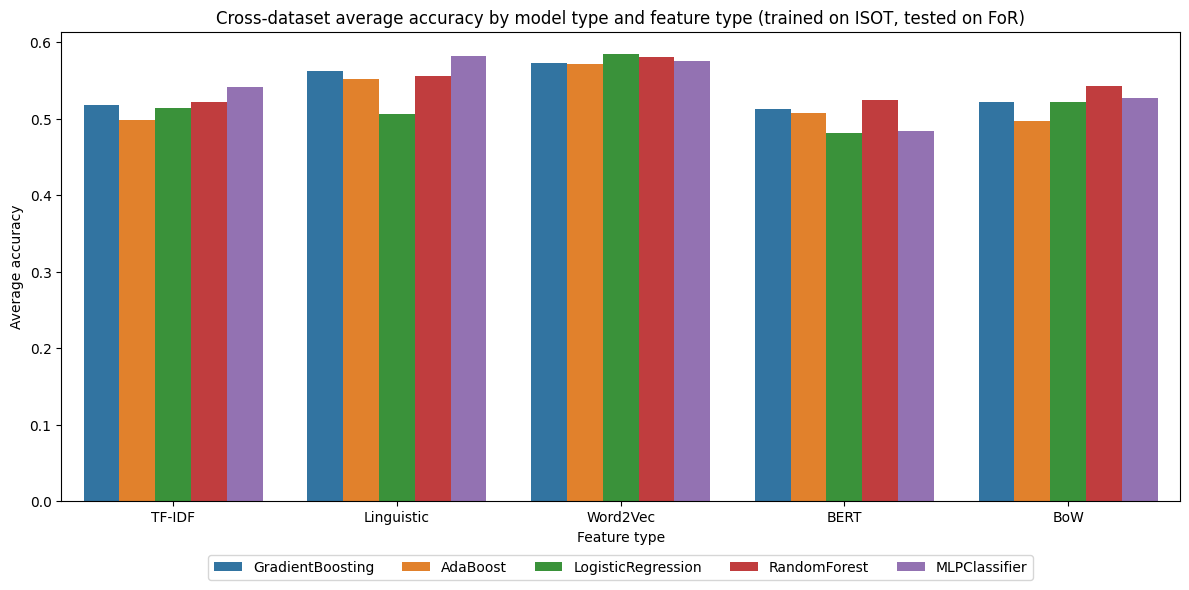

In [98]:
# Average performance per model type and feature type
plt.figure(figsize=(12, 6))
sns.barplot(data=cross_results_isot, x="feature", y="accuracy", hue="model")
plt.title("Cross-dataset average accuracy by model type and feature type (trained on ISOT, tested on FoR)")
plt.xlabel("Feature type")
plt.ylabel("Average accuracy")
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=5)
plt.tight_layout()
plt.show()

In [99]:
# Average performance per model type
cross_results_isot.groupby("model")[["accuracy", "precision", "recall", "f1_score"]].mean().sort_values("accuracy", ascending=False)


,accuracy,precision,recall,f1_score
model,,,,
RandomForest,0.545193,0.574032,0.545193,0.496436
MLPClassifier,0.541784,0.560996,0.541784,0.502680
GradientBoosting,0.537680,0.563692,0.537680,0.483735
AdaBoost,0.525367,0.527170,0.525367,0.448060
LogisticRegression,0.521610,0.559975,0.521610,0.457228


In [100]:
# Average performance per feature type
cross_results_isot.groupby("feature")[["accuracy", "precision", "recall", "f1_score"]].mean().sort_values("accuracy", ascending=False)

,accuracy,precision,recall,f1_score
feature,,,,
Word2Vec,0.577080,0.603649,0.577080,0.548732
Linguistic,0.551918,0.573009,0.551918,0.521504
BoW,0.522210,0.553722,0.522210,0.425968
TF-IDF,0.518674,0.553831,0.518674,0.414995
BERT,0.501752,0.501654,0.501752,0.476941


### 3.2. Train on Fake or Real and test on ISOT

In [101]:
cross_results_for = cross_dataset_evaluation(features_dict_isot, y_isot, "models/FoR")

In [102]:
cross_results_for

,feature,model,accuracy,precision,recall,f1_score
0,TF-IDF,GradientBoosting,0.557664,0.612199,0.557664,0.468052
1,TF-IDF,AdaBoost,0.553744,0.554142,0.553744,0.530743
2,TF-IDF,LogisticRegression,0.521449,0.487774,0.521449,0.370285
3,TF-IDF,RandomForest,0.542229,0.544690,0.542229,0.494898
4,TF-IDF,MLPClassifier,0.499399,0.473944,0.499399,0.437391
5,Linguistic,RandomForest,0.562720,0.613313,0.562720,0.481550
6,Linguistic,LogisticRegression,0.620829,0.667166,0.620829,0.581130
7,Linguistic,AdaBoost,0.596441,0.647563,0.596441,0.542458
8,Linguistic,MLPClassifier,0.651298,0.656752,0.651298,0.644034
9,Linguistic,GradientBoosting,0.560604,0.608013,0.560604,0.479030


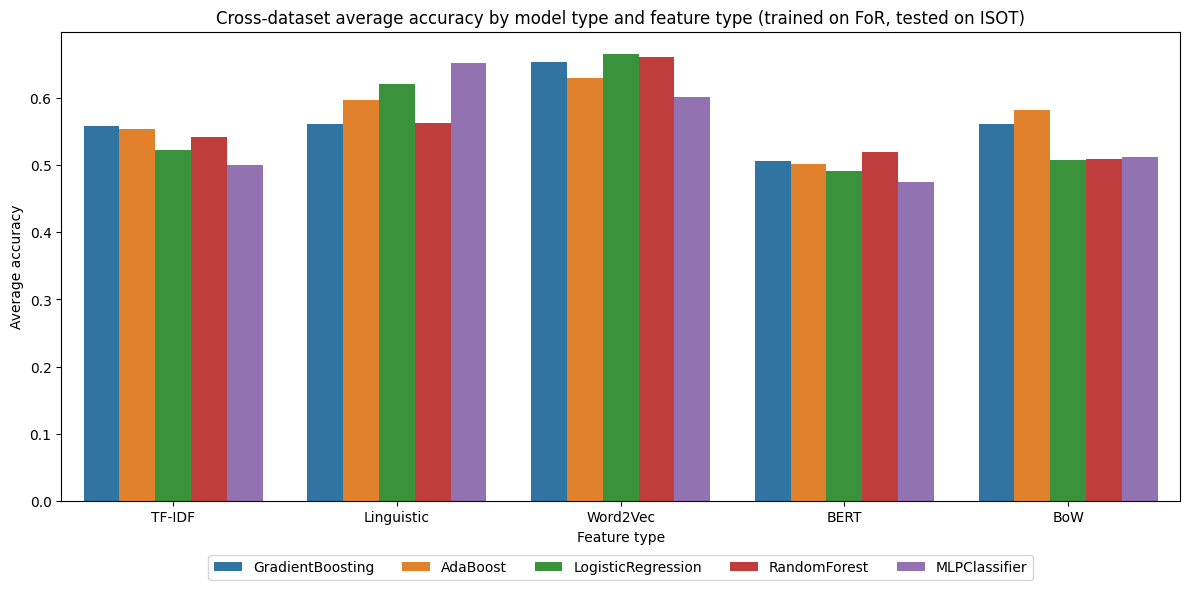

In [103]:
# Average performance per model type and feature type
plt.figure(figsize=(12, 6))
sns.barplot(data=cross_results_for, x="feature", y="accuracy", hue="model")
plt.title("Cross-dataset average accuracy by model type and feature type (trained on FoR, tested on ISOT)")
plt.xlabel("Feature type")
plt.ylabel("Average accuracy")
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=5)
plt.tight_layout()
plt.show()

In [104]:
# Average performance per model type
cross_results_for.groupby("model")[["accuracy", "precision", "recall", "f1_score"]].mean().sort_values("accuracy", ascending=False)

,accuracy,precision,recall,f1_score
model,,,,
AdaBoost,0.572377,0.586707,0.572377,0.552477
GradientBoosting,0.567393,0.594754,0.567393,0.520966
LogisticRegression,0.561241,0.567027,0.561241,0.507418
RandomForest,0.558684,0.571697,0.558684,0.531498
MLPClassifier,0.547641,0.541655,0.547641,0.514235


In [105]:
# Average performance per feature type
cross_results_for.groupby("feature")[["accuracy", "precision", "recall", "f1_score"]].mean().sort_values("accuracy", ascending=False)

,accuracy,precision,recall,f1_score
feature,,,,
Word2Vec,0.641476,0.654693,0.641476,0.637759
Linguistic,0.598379,0.638561,0.598379,0.545640
TF-IDF,0.534897,0.534550,0.534897,0.460274
BoW,0.534144,0.530187,0.534144,0.488572
BERT,0.498441,0.503848,0.498441,0.494350


### 3.3. Grouping results

#### Generalizability per feature type

In [112]:
def plot_average_metric_by_variable(results_a, label_a, results_b, label_b, variable, save_path, metric="accuracy"):
    """
    Plot average performance (accuracy, precision, recall, f1) by feature for two datasets.
    
    Args:
        results_a (pd.DataFrame): Results for dataset A.
        label_a (str): Label for dataset A (e.g. "ISOT").
        results_b (pd.DataFrame): Results for dataset B.
        label_b (str): Label for dataset B (e.g. "FoR").
        variable (str): Name of the variable to group the results by
        metric (str): Metric to compare ("accuracy", "f1_score", etc.).
    """
    # Compute average scores per variable
    avg_a = results_a.groupby(variable)[[metric]].mean().reset_index()
    avg_b = results_b.groupby(variable)[[metric]].mean().reset_index()

    # Add source labels
    avg_a["source"] = label_a
    avg_b["source"] = label_b

    # Combine
    combined = pd.concat([avg_a, avg_b], ignore_index=True)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=combined, x="source", y=metric, hue=variable)
    plt.title(f"Cross-dataset average {metric} by {variable} type")
    plt.xlabel("Dataset (trained on)")
    plt.ylabel(f"Average {metric}")
    plt.legend(bbox_to_anchor=(0.5, -0.13), loc='upper center', ncol=5)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

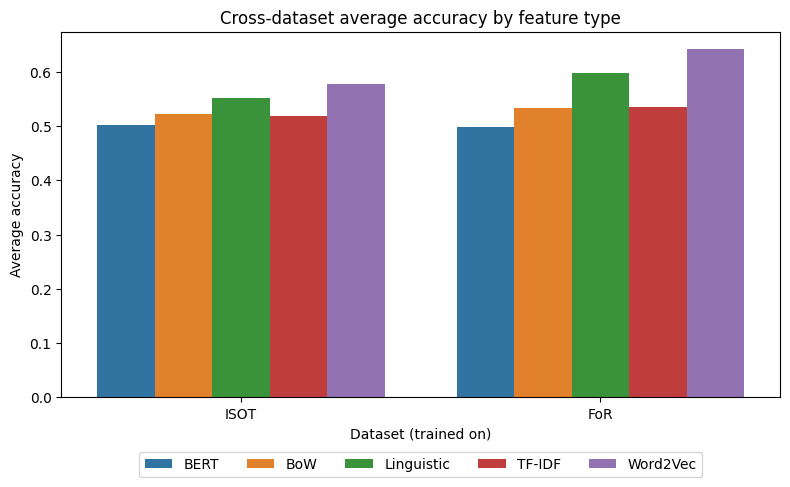

In [113]:
plot_average_metric_by_variable(cross_results_isot, "ISOT", cross_results_for, "FoR", variable="feature", save_path="figures/cross_perf_by_feature.png")

#### Generalizability per model type

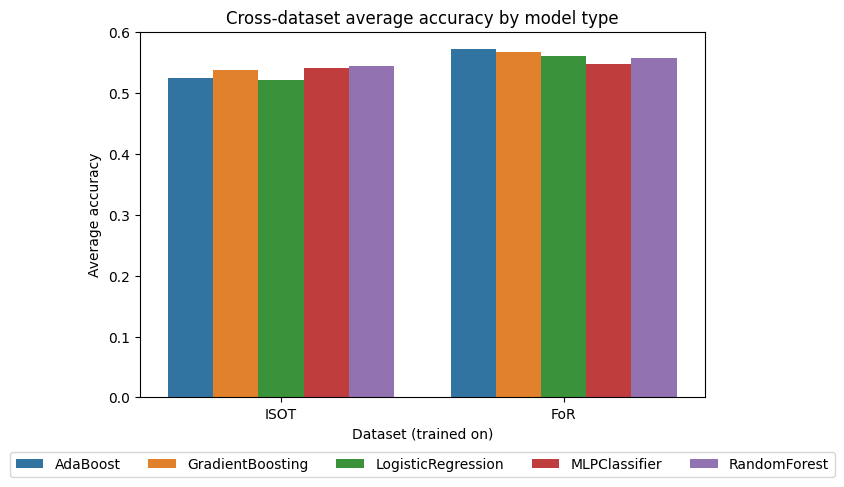

In [114]:
plot_average_metric_by_variable(cross_results_isot, "ISOT", cross_results_for, "FoR", variable="model", save_path="figures/cross_perf_by_model.png")

## 4. Save results

In [30]:
# Combined results
combined_results = pd.concat([
    results_test_for.assign(train_dataset="ISOT", test_dataset="FoR"),
    results_test_isot.assign(train_dataset="FoR", test_dataset="ISOT")
])
combined_results.to_csv("results/cross_eval_results.csv", index=False)

In [29]:
combined_results

,feature,model,accuracy,precision,recall,f1_score,train_dataset,test_dataset
0,TF-IDF,GradientBoosting,0.518074,0.554217,0.518074,0.423230,ISOT,FoR
1,TF-IDF,AdaBoost,0.498185,0.482712,0.498185,0.347195,ISOT,FoR
2,TF-IDF,LogisticRegression,0.513496,0.598955,0.513496,0.380674,ISOT,FoR
3,TF-IDF,RandomForest,0.521547,0.570380,0.521547,0.422378,ISOT,FoR
4,TF-IDF,MLPClassifier,0.542068,0.562889,0.542068,0.501499,ISOT,FoR
5,Linguistic,RandomForest,0.556275,0.591201,0.556275,0.509875,ISOT,FoR
6,Linguistic,LogisticRegression,0.506709,0.507697,0.506709,0.493437,ISOT,FoR
7,Linguistic,AdaBoost,0.552328,0.575824,0.552328,0.515334,ISOT,FoR
8,Linguistic,MLPClassifier,0.581531,0.594831,0.581531,0.566612,ISOT,FoR
9,Linguistic,GradientBoosting,0.562747,0.595490,0.562747,0.522260,ISOT,FoR


## 5. Baseline results vs cross dataset results

### 5.1. ISOT dataset

In [90]:
isot_results = pd.read_csv("results/isot_results.csv")
isot_results

,feature,model,accuracy,precision,recall,f1_score
0,BoW,AdaBoost,0.995078,0.995100,0.995078,0.995078
1,BoW,GradientBoosting,0.996125,0.996139,0.996125,0.996125
2,BoW,LogisticRegression,0.996414,0.996415,0.996414,0.996414
3,BoW,MLPClassifier,0.994655,0.994655,0.994655,0.994655
4,BoW,RandomForest,0.998530,0.998531,0.998530,0.998530
5,TF-IDF,AdaBoost,0.994788,0.994807,0.994788,0.994789
6,TF-IDF,GradientBoosting,0.995813,0.995824,0.995813,0.995813
7,TF-IDF,LogisticRegression,0.989643,0.989652,0.989643,0.989644
8,TF-IDF,MLPClassifier,0.992828,0.992830,0.992828,0.992828
9,TF-IDF,RandomForest,0.998552,0.998555,0.998552,0.998552


In [115]:
print("Baseline avg accuracy :", isot_results["accuracy"].mean())
print("Cross-dataset avg accuracy :", cross_results_isot["accuracy"].mean())

Baseline avg accuracy : 0.9746696773044553
Cross-dataset avg accuracy : 0.5343267561168114


### 5.2. Fake or Real dataset

In [92]:
for_results = pd.read_csv("results/FoR_results.csv")
for_results

,feature,model,accuracy,precision,recall,f1_score
0,BoW,AdaBoost,0.860616,0.862988,0.860616,0.860396
1,BoW,GradientBoosting,0.891713,0.892892,0.891713,0.891635
2,BoW,LogisticRegression,0.916811,0.917315,0.916811,0.916788
3,BoW,MLPClassifier,0.916180,0.916805,0.916180,0.916150
4,BoW,RandomForest,0.913181,0.913312,0.913181,0.913174
5,TF-IDF,AdaBoost,0.857932,0.858623,0.857932,0.857867
6,TF-IDF,GradientBoosting,0.898185,0.898886,0.898185,0.898143
7,TF-IDF,LogisticRegression,0.918074,0.919007,0.918074,0.918031
8,TF-IDF,MLPClassifier,0.928019,0.928410,0.928019,0.928003
9,TF-IDF,RandomForest,0.914601,0.914727,0.914601,0.914595


In [116]:
print("Baseline avg accuracy :", for_results["accuracy"].mean())
print("Cross-dataset avg accuracy :", cross_results_for["accuracy"].mean())

Baseline avg accuracy : 0.8692533543804263
Cross-dataset avg accuracy : 0.5614673259387946
